## Ch 05-1 결정 트리

### 로지스틱 회귀로 와인 분류하기

In [2]:
import pandas as pd
wine = pd.read_csv('https://bit.ly/wine_csv_data')

In [3]:
wine.head()

,alcohol,sugar,pH,class
0,9.4,1.9,3.51,0.0
1,9.8,2.6,3.20,0.0
2,9.8,2.3,3.26,0.0
3,9.8,1.9,3.16,0.0
4,9.4,1.9,3.51,0.0


In [4]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   alcohol  6497 non-null   float64
 1   sugar    6497 non-null   float64
 2   pH       6497 non-null   float64
 3   class    6497 non-null   float64
dtypes: float64(4)
memory usage: 203.2 KB


In [5]:
wine.describe()  # 열에 대한 간략한 통계 출력 (평균, 표준편차, 최대, 최소)

,alcohol,sugar,pH,class
count,6497.000000,6497.000000,6497.000000,6497.000000
mean,10.491801,5.443235,3.218501,0.753886
std,1.192712,4.757804,0.160787,0.430779
min,8.000000,0.600000,2.720000,0.000000
25%,9.500000,1.800000,3.110000,1.000000
50%,10.300000,3.000000,3.210000,1.000000
75%,11.300000,8.100000,3.320000,1.000000
max,14.900000,65.800000,4.010000,1.000000


In [6]:
data = wine[['alcohol', 'sugar', 'pH']]
target = wine['class']

In [7]:
from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=42)  # 테스트 세트 20%

In [8]:
print(train_input.shape, test_input.shape)

(5197, 3) (1300, 3)


In [9]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

In [10]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(train_scaled, train_target)
print(lr.score(train_scaled, train_target))
print(lr.score(test_scaled, test_target))

0.7808350971714451
0.7776923076923077


설명하기 쉬운 모델과 어려운 모델

In [11]:
print(lr.coef_, lr.intercept_)

[[ 0.51268071  1.67335441 -0.68775646]] [1.81773456]


### 결정 트리

In [12]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(train_scaled, train_target)
print(dt.score(train_scaled, train_target))  # 훈련 세트
print(dt.score(test_scaled, test_target))    # 테스트 세트

0.996921300750433
0.8592307692307692


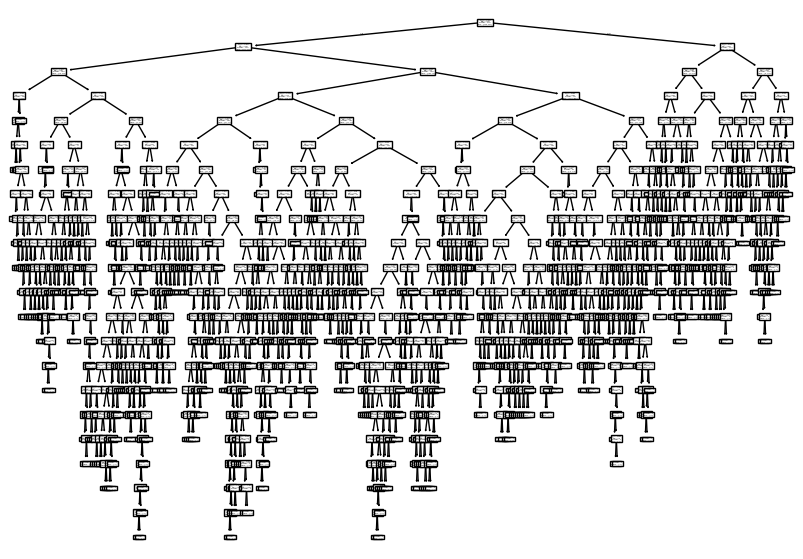

In [13]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.figure(figsize=(10,7))
plot_tree(dt)
plt.show()

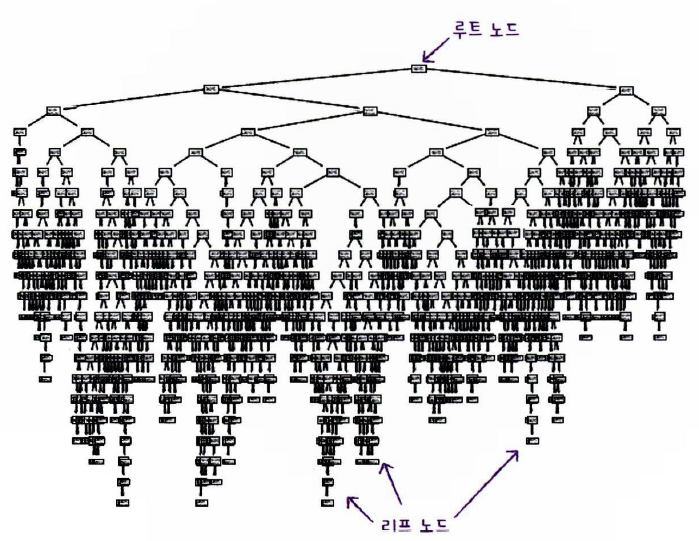

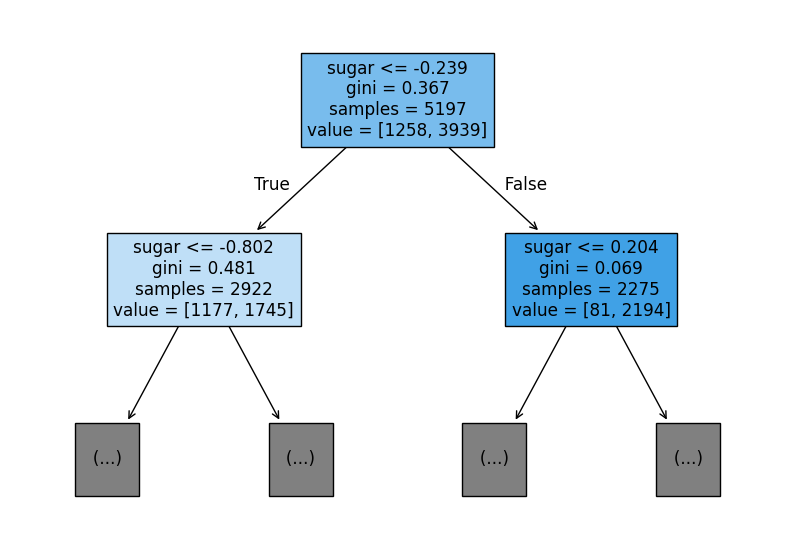

In [14]:
plt.figure(figsize=(10,7))
plot_tree(dt, max_depth=1, filled=True,  # max_depth를 1로 주면 하나의 노드를 확장하여 그림
          feature_names=['alcohol', 'sugar', 'pH'])
plt.show()

* 지니 불순도(gini) : DecisionTreeClassifier 클래스의 criterion 매개 변수의 기본값

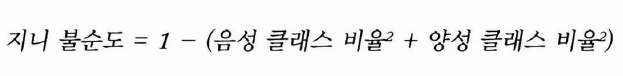

가지치기 (트리의 최대 깊이를 지정하기)

In [15]:
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(train_scaled, train_target)
print(dt.score(train_scaled, train_target))
print(dt.score(test_scaled, test_target))

0.8454877814123533
0.8415384615384616


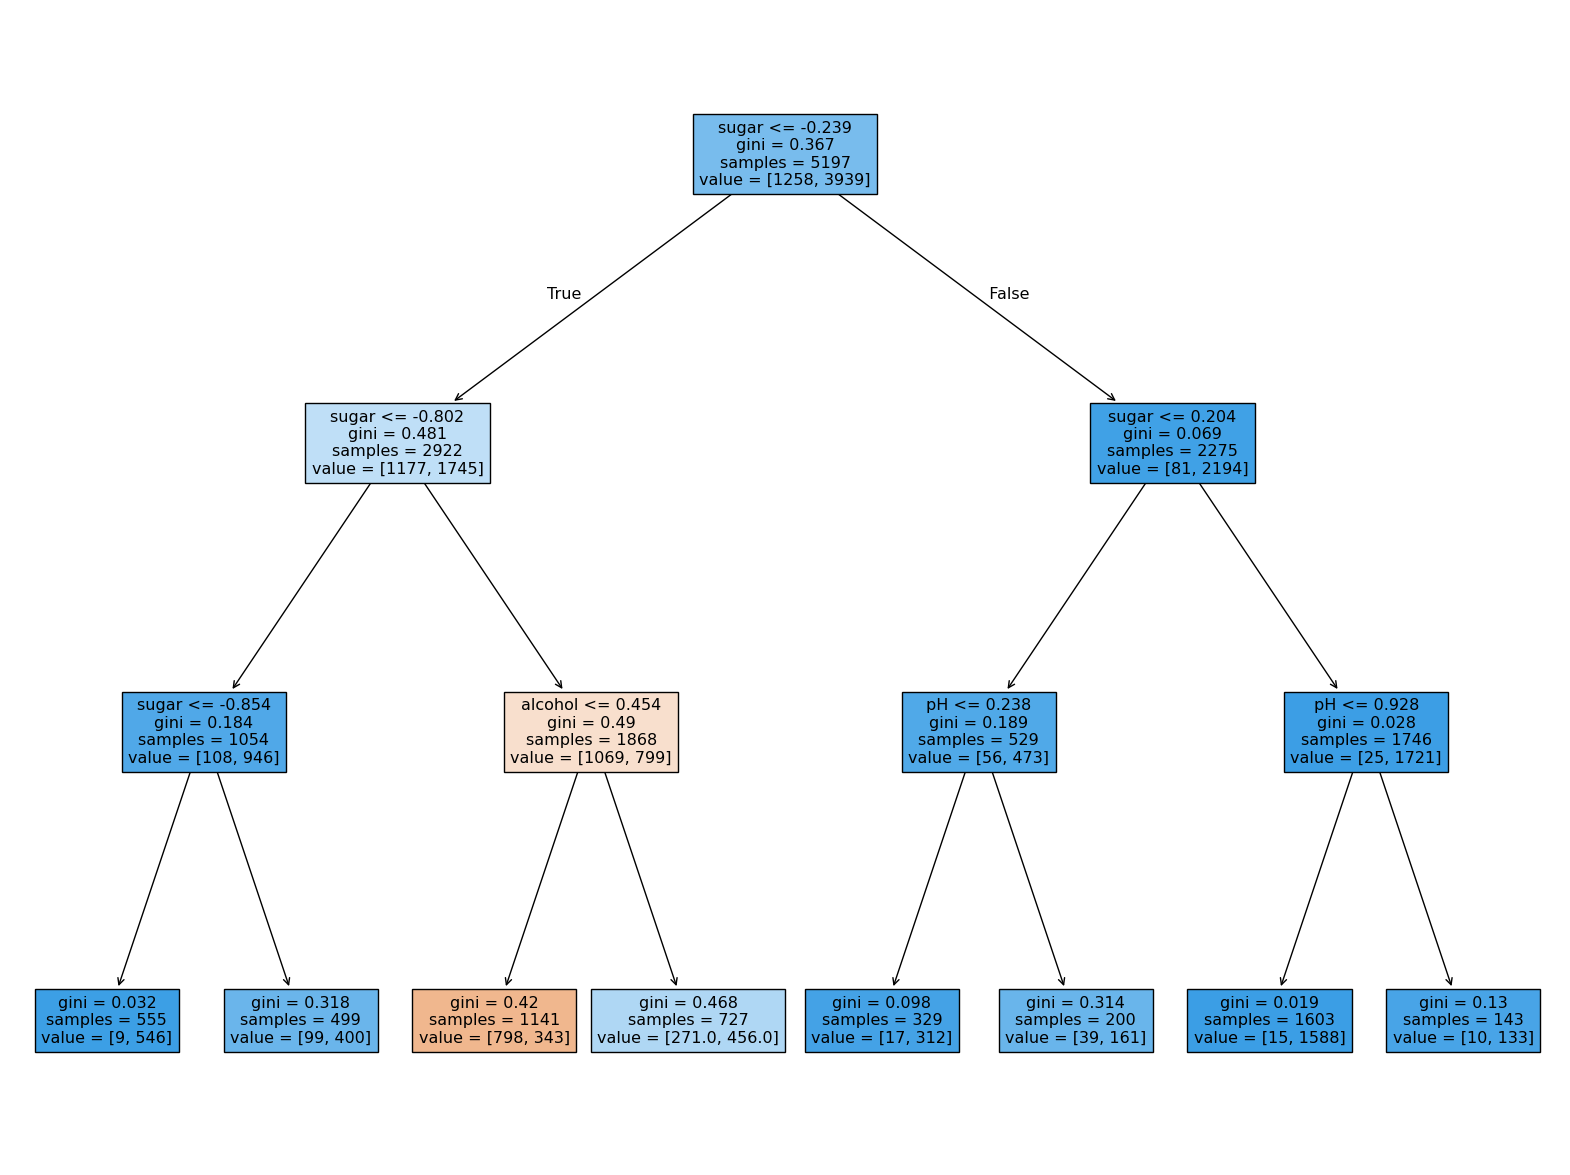

In [16]:
plt.figure(figsize=(20,15))
plot_tree(dt, filled=True, feature_names=['alcohol', 'sugar', 'pH'])
plt.show()

결정 트리는 표준화 전처리 과정이 필요 없음

In [17]:
# 전처리하기 전의 훈련 세트와 테스트 세트로 훈련해보기
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(train_input, train_target)
print(dt.score(train_input, train_target))
print(dt.score(test_input, test_target))

0.8454877814123533
0.8415384615384616


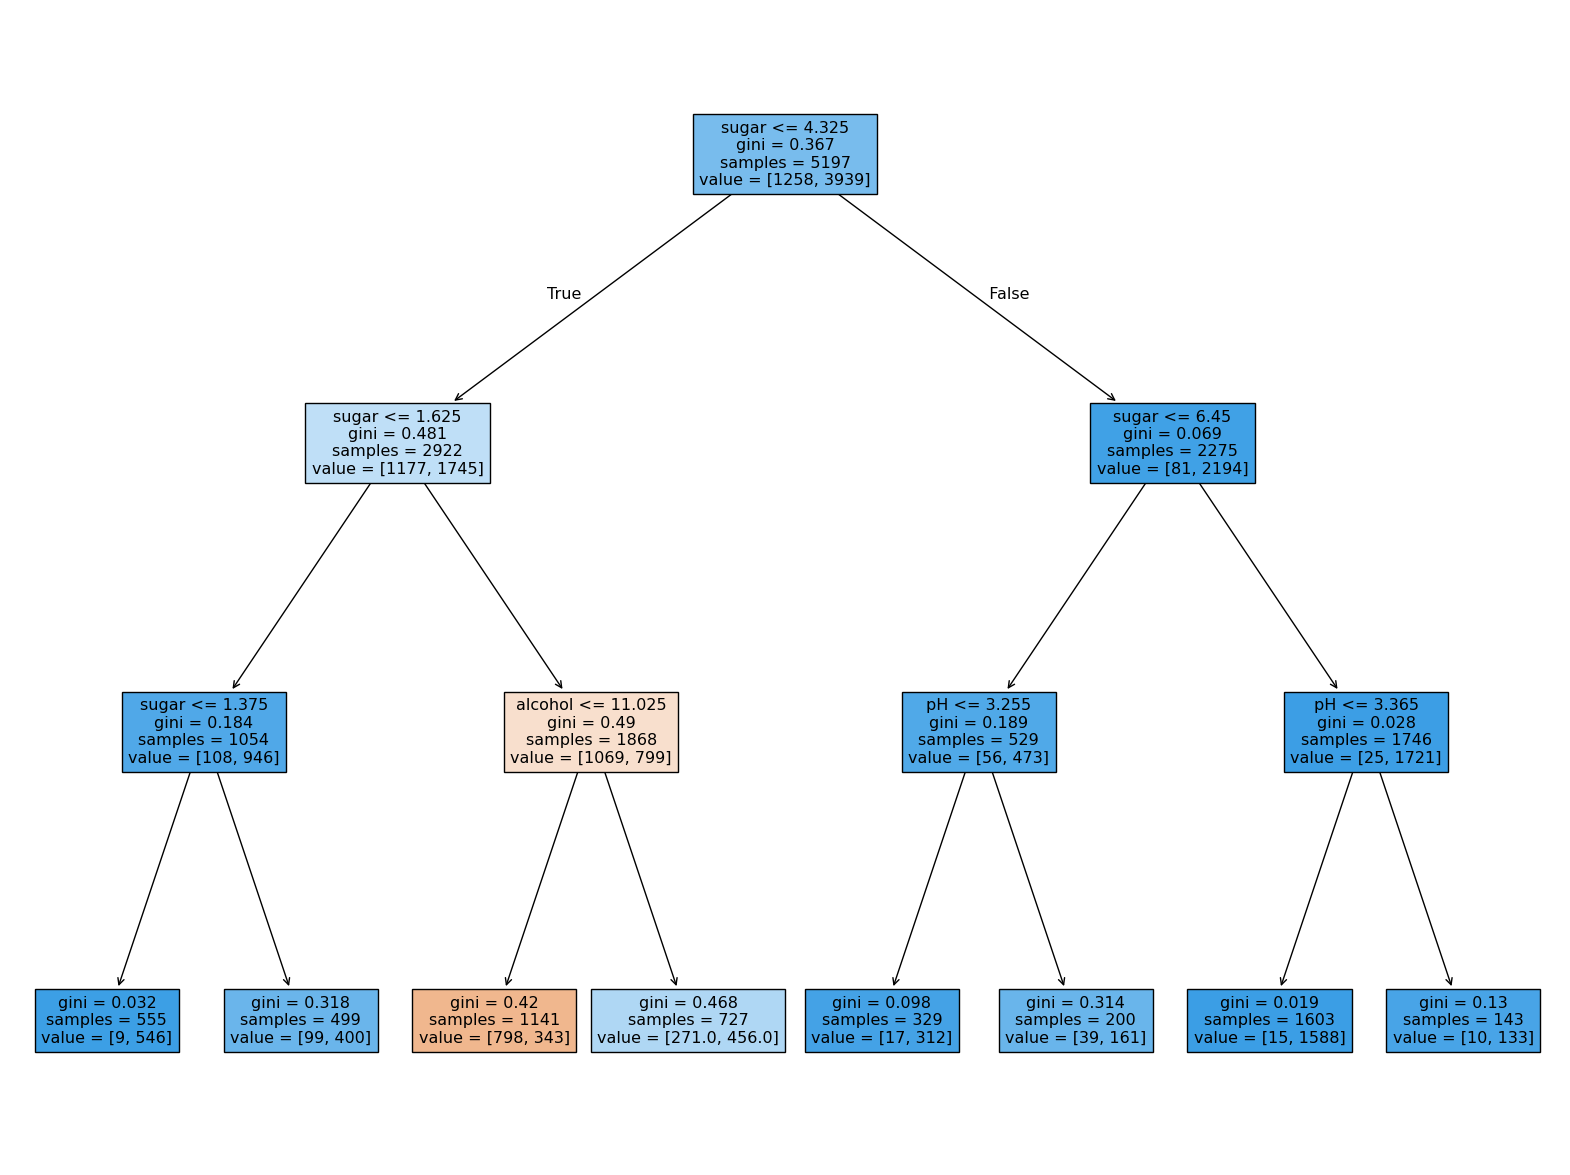

In [18]:
plt.figure(figsize=(20, 15))
plot_tree(dt, filled=True, feature_names=['alcohol', 'sugar','pH'])
plt.show()

In [19]:
print(dt.feature_importances_)  # 특성 중요도 확인

[0.12345626 0.86862934 0.0079144 ]


## Ch 05-2 교차 검증과 그리드 서치

### 검증 세트

테스트 세트를 사용하지 않으면 모델이 과대적합인지 과소적합인지 판단하기 어려움

-> 테스트 세트를 사용하지 않고 측정하는 간단한 방법은 훈련 세르를 또 나눔(검증 세트)

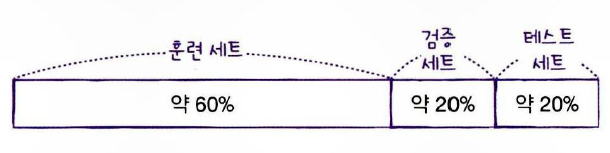

In [20]:
import pandas as pd
wine = pd.read_csv('https://bit.ly/wine_csv_data')

In [21]:
data = wine[['alcohol', 'sugar', 'pH']]
target = wine['class']

In [22]:
from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=42)

In [23]:
# 훈련 세트 sub_input, sub_target과 검증 세트 val_input, val_target 만들기
sub_input, val_input, sub_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

In [24]:
print(sub_input.shape, val_input.shape)

(4157, 3) (1040, 3)


In [25]:
# 훈련 세트와 검증 세트 이용하여 모델을 만들고 평가해보기
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(sub_input, sub_target)
print(dt.score(sub_input, sub_target))
print(dt.score(val_input, val_target))

0.9971133028626413
0.864423076923077


### 교차 검증

* 3-폴드 교차 검증

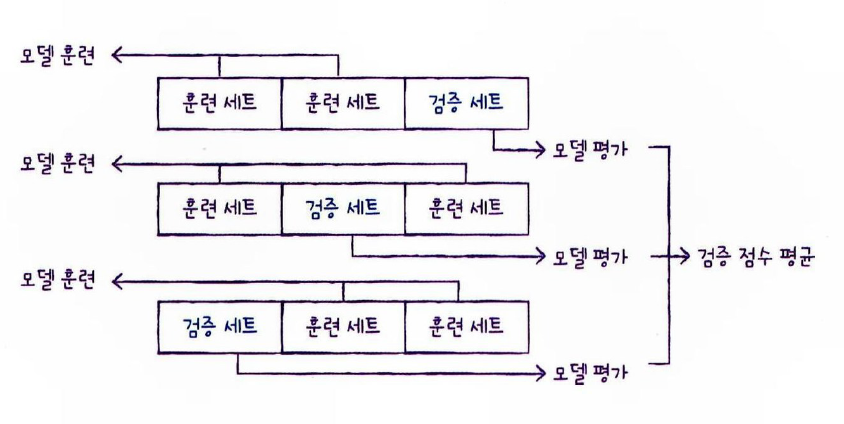

In [26]:
# 사이킷런의 cross_validate() 교차 검증 함수 사용하기
from sklearn.model_selection import cross_validate
scores = cross_validate(dt, train_input, train_target)
print(scores)

{'fit_time': array([0.00614786, 0.0079205 , 0.007092  , 0.00764155, 0.00611496]), 'score_time': array([0.00185251, 0.00184321, 0.00213933, 0.00187683, 0.00207853]), 'test_score': array([0.86923077, 0.84615385, 0.87680462, 0.84889317, 0.83541867])}


fit_time, score_time : 모델을 훈련하는 시간과 검증하는 시간

In [27]:
import numpy as np
print(np.mean(scores['test_score']))

0.855300214703487


* cross_validate()는 훈련 세트를 섞어 폴드를 나누지 않음, 교차 검증시 훈련 세트를 섞으려면 분할기 지정해야 함

-> 회귀 모델 : KFold 분할기, 분류 모델 : StratifiedKFold

In [28]:
from sklearn.model_selection import StratifiedKFold
scores = cross_validate(dt, train_input, train_target, cv=StratifiedKFold())
print(np.mean(scores['test_score']))

0.855300214703487


In [29]:
# 훈련 세트를 섞은 후 10-폴드 교차 검증 수행
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_validate(dt, train_input, train_target, cv=splitter)
print(np.mean(scores))

TypeError: unsupported operand type(s) for /: 'dict' and 'int'

### 하이퍼파라미터 튜닝

* 하이퍼파라미터 : 모델이 학습할 수 없어 사용자가 지정해야하는 파라미터

* 그리드 서치: 사이킷런의 GridSearchCV 클래스는 하이퍼파라미터 탐색과 교차 검증을 한번에 수행

In [30]:
# GridSearchCV 클래스를 임포트, 탐색할 매개변수와 값의 리스트를 딕셔너리로 만들기
from sklearn.model_selection import GridSearchCV
params = {'min_impurity_decrease': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]}

In [31]:
# 탐색 대상 모델과 params 변수 전달하여 그리드 서치 객체 만들기
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)

In [32]:
gs.fit(train_input, train_target)

,estimator,DecisionTreeC...ndom_state=42)
,param_grid,"{'min_impurity_decrease': [0.0001, 0.0002, ...]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [33]:
dt = gs.best_estimator_
print(dt.score(train_input, train_target))

0.9615162593804117


In [34]:
print(gs.best_params_)

{'min_impurity_decrease': 0.0001}


In [35]:
print(gs.cv_results_['mean_test_score'])

[0.86819297 0.86453617 0.86492226 0.86780891 0.86761605]


In [36]:
print(gs.cv_results_['params'][gs.best_index_])

{'min_impurity_decrease': 0.0001}


In [37]:
params = {'min_impurity_decrease': np.arange(0.0001, 0.001, 0.0001),
          'max_depth': range(5, 20, 1),
          'min_samples_split': range(2, 100, 10)
          }

In [38]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)
gs.fit(train_input, train_target)

,estimator,DecisionTreeC...ndom_state=42)
,param_grid,"{'max_depth': range(5, 20), 'min_impurity_decrease': array([0.0001... 0.0009]), 'min_samples_split': range(2, 100, 10)}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [39]:
# 최상의 매개변수 조합 확인
print(gs.best_params_)

{'max_depth': 14, 'min_impurity_decrease': np.float64(0.0004), 'min_samples_split': 12}


In [40]:
# 최상의 교차 검증 점수 확인
print(np.max(gs.cv_results_['mean_test_score']))

0.8683865773302731


매개 변수의 값이 수치일 때 값의 범위나 간격을 미리 정하기 어려움

너무 많은 매개 변수 조건이 있어 그리드 서치 수행 시간이 오래 걸릴 수 있음

->  랜덤 서치 : 매개 변수를 샘플링할 수 있는 확률 분포 객체 전달


In [41]:
from scipy.stats import uniform, randint  # 주어진 범위에서 고르게 값을 뽑음

In [42]:
# 0에서 10 사이의 범위를 갖는 randint 객체 만들고, 10개의 숫자를 샘플링
rgen = randint(0, 10)
rgen.rvs(10)

array([1, 2, 0, 1, 4, 2, 7, 8, 9, 7])

In [43]:
np.unique(rgen.rvs(1000), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 97, 100,  96,  98, 103,  88, 111, 110, 100,  97]))

In [44]:
ugen = uniform(0, 1)
ugen.rvs(10)

array([0.45594522, 0.23747102, 0.6891599 , 0.16356047, 0.02347855,
       0.41745102, 0.19248856, 0.66043174, 0.15836802, 0.09676377])

In [45]:
params = {'min_impurity_decrease': uniform(0.0001, 0.001),
          'max_depth': randint(20, 50),
          'min_samples_split': randint(2, 25),
          'min_samples_leaf': randint(1, 25),
          }

In [46]:
from sklearn.model_selection import RandomizedSearchCV
rs = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), params,
                        n_iter=100, n_jobs=-1, random_state=42)
rs.fit(train_input, train_target)

,estimator,DecisionTreeC...ndom_state=42)
,param_distributions,"{'max_depth': <scipy.stats....x7ad0775cea70>, 'min_impurity_decrease': <scipy.stats....x7ad078a97bb0>, 'min_samples_leaf': <scipy.stats....x7ad078a90ca0>, 'min_samples_split': <scipy.stats....x7ad078a90c70>}"
,n_iter,100
,scoring,None
,n_jobs,-1
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [47]:
print(rs.best_params_)

{'max_depth': 39, 'min_impurity_decrease': np.float64(0.00034102546602601173), 'min_samples_leaf': 7, 'min_samples_split': 13}


In [48]:
print(np.max(rs.cv_results_['mean_test_score']))

0.8695428296438884


In [49]:
dt = rs.best_estimator_
print(dt.score(test_input, test_target))

0.86


## Ch 05-3 트리의 앙상블

### 정형 데이터와 비정형 데이터

* 정형 데이터 : 구조로 되어 있는 데이터 -> 앙상블 (가장 뛰어난 성과내는 알고리즘)
* 비정형 데이터 : 데이터베이스나 엑셀로 표현하기 어려운 데이터


### 랜덤 포레스트 
: 앙상블 학습의 대표 주자

: 안정적인 성능

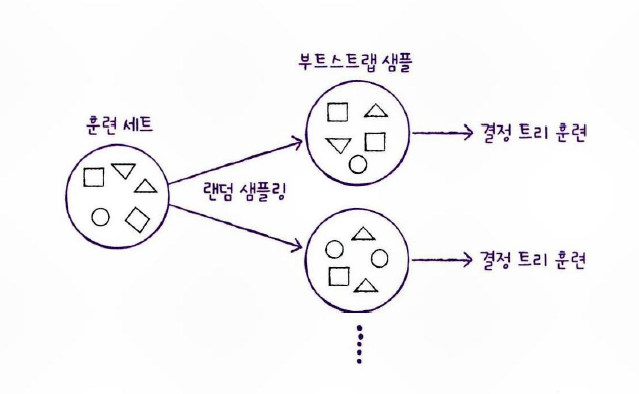

In [50]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
wine = pd.read_csv('https://bit.ly/wine_csv_data')
data = wine[['alcohol', 'sugar', 'pH']]
target = wine['class']
train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=42)

In [51]:
# cross_validate()함수 사용하여 교차 검증
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_jobs=-1, random_state=42)
scores = cross_validate(rf, train_input, train_target,
                        return_train_score=True, n_jobs=-1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9973541965122431 0.8905151032797809


In [52]:
# 특성 중요도 출력
rf.fit(train_input, train_target)
print(rf.feature_importances_)

[0.23167441 0.50039841 0.26792718]


* 랜덤 포레스트에선 OOB 샘플(부트스트랩 샘플에 포함되지 않고 남는 샘플)을 이용하여 결정 트리를 평가할 수 있음

In [53]:
rf = RandomForestClassifier(oob_score=True, n_jobs=-1, random_state=42)
rf.fit(train_input, train_target)
print(rf.oob_score_)

0.8934000384837406


### 엑스트라 트리
: 기본적으로 100개의 결정 트리 훈련

: 결정 트리가 제공하는 대부분의 매개 변수 지원

: 전체 특성 중에 일부 특성을 랜덤하게 선택하여 노드를 분할하는 데 사용

: 랜덤 포레스트와 다르게 부트스트랩 샘플을 사용하지 않음

In [54]:
from sklearn.ensemble import ExtraTreesClassifier
et = ExtraTreesClassifier(n_jobs=-1, random_state=42)
scores = cross_validate(et, train_input, train_target,
                        return_train_score=True, n_jobs=-1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9974503966084433 0.8887848893166506


In [55]:
et.fit(train_input, train_target)
print(et.feature_importances_)

[0.20183568 0.52242907 0.27573525]


### 그레이디언트 부스팅
: 깊이가 얕은 결정 트리를 사용하여 이전 트리의 오차를 보완하는 방식

: 기본적으로 깊이가 3인 결정 트리 100개 사용

: 과대적합에 강하고, 일반적으로 높은 일반화 성능 기대

: 경사 하강법을 사용하여 트리를 앙상블에 추가

In [56]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=42)
scores = cross_validate(gb, train_input, train_target,
                        return_train_score=True, n_jobs=-1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.8881086892152563 0.8720430147331015


In [57]:
# 학습률을 증가시키고 트리의 개수 늘리기
gb = GradientBoostingClassifier(n_estimators=500, learning_rate=0.2,
                                random_state=42)
scores = cross_validate(gb, train_input, train_target,
                        return_train_score=True, n_jobs=-1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9464595437171814 0.8780082549788999


In [58]:
gb.fit(train_input, train_target)
print(gb.feature_importances_)

[0.15887763 0.6799705  0.16115187]


### 히스토그램 기반 그레이디언트 부스팅
: 입력 특성을 256개 구간으로 나눔 (노드 분할시 최적의 분할을 매우 빠르게 찾을수 있음)

: 구간 중에 하나를 떼어 놓고 누락된 값을 위해 사용(전처리 필요 x)

In [59]:
from sklearn.ensemble import HistGradientBoostingClassifier
hgb = HistGradientBoostingClassifier(random_state=42)
scores = cross_validate(hgb, train_input, train_target,
                        return_train_score=True)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9321723946453317 0.8801241948619236


In [ ]:
# permutation_importance() 이용하여 특성 중요도 계산하기
from sklearn.inspection import permutation_importance

hgb.fit(train_input, train_target)
result = permutation_importance(hgb, train_input, train_target,
                                n_repeats=10, random_state=42, n_jobs=-1)
print(result.importances_mean)

[0.08876275 0.23438522 0.08027708]


In [62]:
result = permutation_importance(hgb, test_input, test_target,
                                n_repeats=10, random_state=42, n_jobs=-1)
print(result.importances_mean)

[0.05969231 0.20238462 0.049     ]


In [63]:
hgb.score(test_input, test_target)

0.8723076923076923

In [66]:
# XGBoost를 사용해 와인 데이터의 교차 검증 점수 확인
from xgboost import XGBClassifier
xgb = XGBClassifier(tree_method='hist', random_state=42)
scores = cross_validate(xgb, train_input, train_target,
                        return_train_score=True, n_jobs=-1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9567059184812372 0.8783915747390243


In [69]:
# LightGBM로 테스트 해보기!
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(random_state=42)
scores = cross_validate(lgb, train_input, train_target,
                        return_train_score=True, n_jobs=-1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

[LightGBM] [Info] Number of positive: 3151, number of negative: 1007
[LightGBM] [Info] Number of positive: 3151, number of negative: 1006
[LightGBM] [Info] Number of positive: 3151, number of negative: 1007
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.189384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 372
[LightGBM] [Info] Number of positive: 3152, number of negative: 1006
[LightGBM] [Info] Number of positive: 3151, number of negative: 1006
[LightGBM] [Info] Number of data points in the train set: 4158, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.757816 -> initscore=1.140744
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.118453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.140242 